In [ ]:
from google.colab import auth
from google.colab import drive
auth.authenticate_user()
print('Authenticated')
drive.mount('/content/drive')

Authenticated
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q scann

In [ ]:
from typing import Dict, Text
import os

from google.cloud import bigquery
from google.cloud.bigquery_storage_v1beta1 import BigQueryStorageClient
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

# Dataset

In [ ]:
project_id = "peya-data-analyt-factory-stg"  #@param ["peya-data-analyt-factory-stg", "peya-food-and-groceries", "peya-growth-and-onboarding"]
client = bigquery.client.Client(project=project_id)
bq_storage_client = BigQueryStorageClient()

In [ ]:
MINIMUM_PRODUCTS = 5
MINIMUM_ORDERS = 2
data_project_id = "peya-food-and-groceries"
data_dataset_id = "user_fiorella_dirosario"
data_table_orders = "order_sep2020_sep2021"
data_table_order_details = "order_details_sep2020_sep2021"
data_table_users = "attributes_sep2020_sep2021"
data_table_products = "product_attributes_sep2020_sep2021"

interaction_query_train = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT product_id) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.product_id IS NOT NULL
    GROUP BY 1
)
SELECT DISTINCT
    CAST(uo.user_id AS STRING) AS user_id
  , CAST(od.product_id AS STRING) AS product_id
  --, uo.order_id
  --, uo.timestamp
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
ON uo.order_id = od.order_id
LEFT JOIN products_by_user pbu ON pbu.user_id = uo.user_id
WHERE uo.user_id IS NOT NULL
  AND od.product_id IS NOT NULL
  AND cant_products >= minimum_products
  AND cant_orders >= minimum_orders
  AND uo.order_id != pbu.last_order_id 
"""

interaction_query_test = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT product_id) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.product_id IS NOT NULL
    GROUP BY 1
)
SELECT DISTINCT
    CAST(uo.user_id AS STRING) AS user_id
  , CAST(od.product_id AS STRING) AS product_id
  --, uo.order_id
  --, uo.timestamp
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
ON
  uo.order_id = od.order_id
LEFT JOIN 
  products_by_user pbu 
ON 
  pbu.user_id = uo.user_id
WHERE 
  uo.user_id IS NOT NULL
  AND od.product_id IS NOT NULL
  AND cant_products >= minimum_products
  AND cant_orders >= minimum_orders
  AND uo.order_id = pbu.last_order_id 
"""

product_query = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};


WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT od.product_id) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.product_id IS NOT NULL
    GROUP BY 1
    HAVING 
      cant_products >= minimum_products AND cant_orders >= minimum_orders
)
, products AS (
  SELECT DISTINCT
    od.product_id
  FROM
    `{data_project_id}.{data_dataset_id}.{data_table_order_details}` od
  JOIN 
    `{data_project_id}.{data_dataset_id}.{data_table_orders}` uo ON uo.order_id = od.order_id
  JOIN 
    products_by_user pbu ON pbu.user_id = uo.user_id
)

SELECT 
    CAST(pa.product_id AS STRING) AS product_id
  , IF(pa.category_id IS NULL, "", CAST(pa.category_id AS STRING))  AS category_id
  , IF(pa.brand_id IS NULL, "", CAST(pa.brand_id AS STRING)) AS brand_id
  , CAST(pa.age AS STRING) AS age
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_products}` pa
JOIN products p ON p.product_id = pa.product_id
"""

user_query = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
    uo.user_id
    , COUNT(DISTINCT product_id) as cant_products
    , COUNT(DISTINCT uo.order_id) as cant_orders
    , MAX(uo.order_id) as last_order_id
    FROM 
    `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
    `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON uo.order_id = od.order_id  
    WHERE uo.user_id IS NOT NULL
    AND od.product_id IS NOT NULL
    GROUP BY 1
)
SELECT 
    CAST(ua.user_id AS STRING) AS user_id
  , CAST(ua.city_id AS STRING) AS city_id
  , ua.platform
  , IF(ua.segment IS NULL, "Not set", ua.segment) AS segment
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_users}` ua
LEFT JOIN products_by_user pbu ON pbu.user_id = ua.user_id
WHERE cant_products >= minimum_products
      AND cant_orders >= minimum_orders
"""

interactions_train = (
    client.query(interaction_query_train)
    .result()
    .to_arrow(bqstorage_client=bq_storage_client)
    .to_pandas()
)

interactions_test = (
    client.query(interaction_query_test)
    .result()
    .to_arrow(bqstorage_client=bq_storage_client)
    .to_pandas()
)

users = (
    client.query(user_query)
    .result()
    .to_arrow(bqstorage_client=bq_storage_client)
    .to_pandas()
)
products = (
    client.query(product_query)
    .result()
    .to_arrow(bqstorage_client=bq_storage_client)
    .to_pandas()
)

user_ids = users["user_id"].unique().tolist()
product_ids = products["product_id"].unique().tolist()

In [ ]:
interactions_train_ds = tf.data.Dataset.from_tensor_slices(interactions_train.to_dict(orient="list"))
interactions_train_ds = interactions_train_ds.map(lambda x: {"user_id": x["user_id"], "product_id": x["product_id"]})
interactions_test_ds = tf.data.Dataset.from_tensor_slices(interactions_test.to_dict(orient="list"))
interactions_test_ds = interactions_test_ds.map(lambda x: {"user_id": x["user_id"], "product_id": x["product_id"]})

users_ds = tf.data.Dataset.from_tensor_slices(users.to_dict(orient="list"))
products_ds = tf.data.Dataset.from_tensor_slices(products.to_dict(orient="list"))


tf.random.set_seed(42)
interactions_train_ds = interactions_train_ds.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

for k in interactions_train_ds.take(1).as_numpy_iterator():
    print(k)
for k in products_ds.take(1).as_numpy_iterator():
    print(k)
for k in users_ds.take(1).as_numpy_iterator():
    print(k)

{'user_id': b'22576781', 'product_id': b'2077843000007'}
{'product_id': b'1245', 'category_id': b'', 'brand_id': b'', 'age': b'2271'}
{'user_id': b'4655437', 'city_id': b'134', 'platform': b'ANDROID', 'segment': b'Not set'}


In [ ]:
products_ds = products_ds.map(lambda x: x["product_id"])
users_ds = users_ds.map(lambda x: x["user_id"])

# Modeling (matrix factorization)
[Reference](https://www.tensorflow.org/recommenders/examples/basic_retrieval)
* The embedding dimention is plus 1 to account for unknown tokens.[link text](https://)

In [ ]:
class MarketsModel(tfrs.Model):

  def __init__(
      self,
      user_model: tf.keras.Model,
      product_model: tf.keras.Model,
      task: tf.keras.layers.Layer
      ):
    super().__init__()
    self.user_model = user_model
    self.product_model = product_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(
      self,
      features: Dict[Text, tf.Tensor],
      training=False) -> tf.Tensor:
    user_embeddings = self.user_model(features["user_id"])
    positive_product_embeddings = self.product_model(features["product_id"])
    compute_metrics = False if training else True
    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_product_embeddings, compute_metrics=compute_metrics)

embedding_dimension = 32

user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=tf.convert_to_tensor(user_ids), mask_token=None),
  tf.keras.layers.Embedding(len(user_ids) + 1, embedding_dimension)
])

product_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=tf.convert_to_tensor(product_ids), mask_token=None),
  tf.keras.layers.Embedding(len(product_ids) + 1, embedding_dimension)
])

metrics = tfrs.metrics.FactorizedTopK(
  candidates=products_ds.batch(128).map(product_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

In [ ]:
model = MarketsModel(user_model, product_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))


In [ ]:
cached_train = interactions_train_ds.batch(8192).cache()
cached_test = interactions_test_ds.batch(8192).cache()
history = model.fit(cached_train, epochs=5)

Epoch 1/5
1927/1927 [==============================] - 359s 185ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 69266.5476 - regularization_loss: 0.0000e+00 - total_loss: 69266.5476
Epoch 2/5
1927/1927 [==============================] - 29s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 64513.4405 - regularization_loss: 0.0000e+00 - total_loss: 64513.4405
Epoch 3/5
1927/1927 [==============================] - 29s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 

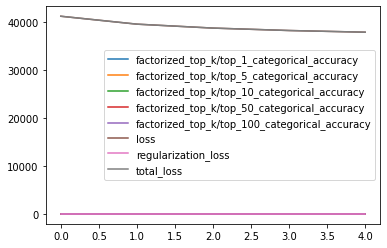

In [ ]:
pd.DataFrame(history.history).plot()


In [ ]:
#model.evaluate(cached_train, return_dict=True)

## Making **predictions**
### BruteForce

In [ ]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((products_ds.batch(100), products_ds.batch(100).map(model.product_model)))
)

# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :20]}")

Recommendations for user 42: [b'7791337002012' b'7790742172006' b'7791337000926' b'7791813421580'
 b'7790742333605' b'7790895010088' b'7791813421917' b'7790742172105'
 b'7796989075803' b'7791337001978']


In [ ]:
%timeit _, titles = index(tf.constant(["42"]))


1000 loops, best of 5: 1.51 ms per loop


## ScaNN

In [ ]:
scann = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
scann.index_from_dataset(
  tf.data.Dataset.zip((products_ds.batch(100), products_ds.batch(100).map(model.product_model)))
)

In [ ]:
_, titles = scann(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :20]}")

Recommendations for user 42: [b'7790742172006' b'7791337002012' b'7791337001961' b'7791337000926'
 b'7790957000545' b'7793890253320' b'7791337002401' b'7791813421580'
 b'7791337091580' b'7790742165909']


In [ ]:
%timeit _, titles = scann(tf.constant(["42"]))


1000 loops, best of 5: 1.89 ms per loop


In [ ]:
xx = []
step = 1000
for x in range(0, len(user_ids), step):
    tmp = index(tf.constant([user_ids[x:x+step]]))
    xx.append([tmp[0].numpy(), tmp[1].numpy()])

In [ ]:
score = np.concatenate([k[0] for k in xx], axis=1).squeeze()


In [ ]:
recommendation = np.concatenate([k[1] for k in xx], axis=1).squeeze()
recommendation = pd.DataFrame(recommendation, index=user_ids).stack().reset_index()
recommendation.columns = ["user_id", "rank", "product_id"]
recommendation['product_id'] = recommendation['product_id'].apply(lambda x: x.decode())

recommendation


,user_id,rank,product_id
0,4655437,0,8480017203809
1,4655437,1,77912268
2,4655437,2,7791813050520
3,4655437,3,8480017300768
4,4655437,4,7798130951776
...,...,...,...
4363445,35417324,5,7790828102095
4363446,35417324,6,7790022000357
4363447,35417324,7,7790383000102
4363448,35417324,8,7790070508348


In [ ]:
recommendation.to_gbq(
    destination_table="dataton_multiverse.user_recommendation_baseline",
    project_id=project_id,
    if_exists="replace"
)

1it [00:49, 49.53s/it]


## Saving Model


In [ ]:
ouput_path = "/content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/"  #@param ["/content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/", "/content/models/"]

In [ ]:
path = os.path.join(ouput_path, "base_line_index")
if not os.path.exists(path):
    os.makedirs(path)
tf.saved_model.save(index, path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/base_line_index/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/recsys-dataton/models/base_line_index/assets
